# 群聊

群聊是一种设计模式，其中一组代理共享一个共同的消息线程：它们都订阅和发布到同一个主题。每个参与的代理都专门负责特定任务，例如在协作写作任务中的作家、插画师和编辑。您还可以包含一个代表人类用户的代理，以在需要时帮助指导其他代理。

在群聊中，参与者轮流发布消息，这个过程是顺序的 —— 一次只有一个代理在工作。在底层，轮次的顺序由群聊管理器代理维护，该代理在收到消息时选择下一个发言的代理。选择下一个代理的具体算法可以根据您的应用需求而变化。通常使用轮询算法或带有 LLM 模型的选择器。

群聊对于将复杂任务动态分解为可由具有明确角色的专门代理处理的较小任务很有用。还可以将群聊嵌套成层次结构，每个参与者都是一个递归群聊。

在这个例子中，我们使用 AutoGen 的核心 API 通过事件驱动代理来实现群聊模式。请先阅读[Topics and Subscriptions](../core-concepts/topic-and-subscription.md)以理解概念，然后阅读[Messages and Communication](../framework/message-and-communication.ipynb)以了解发布-订阅的 API 用法。我们将演示一个简单的群聊示例，其中群聊管理器使用基于 LLM 的选择器，来为儿童故事书创建内容。

```{note}
虽然这个例子说明了群聊机制，但它很复杂，代表了一个起点，您可以从这里构建自己的群聊系统，包含自定义代理和发言者选择算法。[AgentChat API](../../agentchat-user-guide/index.md) 有一个内置的选择器群聊实现。如果您不想使用核心 API，可以使用它。
```

我们将使用 [rich](https://github.com/Textualize/rich) 库以良好的格式显示消息。

In [1]:
# ! pip install rich

In [2]:
import json
import string
import uuid
from typing import List

import openai
from autogen_core.application import SingleThreadedAgentRuntime
from autogen_core.base import MessageContext, TopicId
from autogen_core.components import (
    DefaultTopicId,
    FunctionCall,
    Image,
    RoutedAgent,
    TypeSubscription,
    message_handler,
)
from autogen_core.components.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)
from autogen_core.components.tools import FunctionTool
from autogen_ext.models import OpenAIChatCompletionClient
from IPython.display import display  # type: ignore
from pydantic import BaseModel
from rich.console import Console
from rich.markdown import Markdown

## 消息协议

群聊模式的消息协议很简单。
1. 首先，用户或外部代理向所有参与者的共同主题发布 `GroupChatMessage` 消息。
2. 群聊管理器选择下一个发言者，向该代理发送 `RequestToSpeak` 消息。
3. 代理在收到 `RequestToSpeak` 消息后向共同主题发布 `GroupChatMessage` 消息。
4. 这个过程持续进行，直到群聊管理器达到终止条件，此时停止发出 `RequestToSpeak` 消息，群聊结束。

下图说明了上述步骤 2 到 4。

![Group chat message protocol](groupchat.svg)

In [3]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass

## 基础群聊代理

让我们首先定义只使用 LLM 模型生成文本的代理类。这将作为群聊中所有 AI 代理的基类。


In [4]:
class BaseGroupChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.extend(
            [
                UserMessage(content=f"Transferred to {message.body.source}", source="system"),
                message.body,
            ]
        )

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        completion = await self._model_client.create([self._system_message] + self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        Console().print(Markdown(completion.content))
        # print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )

## 作家和编辑代理

使用基类，我们可以用不同的系统消息定义作家和编辑代理。

In [5]:
class WriterAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are a Writer. You produce good work.",
        )


class EditorAgent(BaseGroupChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Editor. Plan and guide the task given by the user. Provide critical feedbacks to the draft and illustration produced by Writer and Illustrator. "
            "Approve if the task is completed and the draft and illustration meets user's requirements.",
        )

## 带图像生成的插画师代理

现在让我们定义使用 DALL-E 模型根据提供的描述生成插图的 `IllustratorAgent`。
我们使用 {py:class}`~autogen_core.components.tools.FunctionTool` 包装器将图像生成器设置为工具，并使用模型客户端进行工具调用。

In [6]:
class IllustratorAgent(BaseGroupChatAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Illustrator. You use the generate_image tool to create images given user's requirement. "
            "Make sure the images have consistent characters and style.",
        )
        self._image_client = image_client
        self._image_gen_tool = FunctionTool(
            self._image_gen, name="generate_image", description="Call this to generate an image. "
        )

    async def _image_gen(
        self, character_appearence: str, style_attributes: str, worn_and_carried: str, scenario: str
    ) -> str:
        prompt = f"Digital painting of a {character_appearence} character with {style_attributes}. Wearing {worn_and_carried}, {scenario}."
        response = await self._image_client.images.generate(
            prompt=prompt, model="dall-e-3", response_format="b64_json", size="1024x1024"
        )
        return response.data[0].b64_json  # type: ignore

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:  # type: ignore
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history,
            tools=[self._image_gen_tool],
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            Console().print(arguments)
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            image = Image.from_pil(image.image.resize((256, 256)))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

## 用户代理

在定义了所有 AI 代理之后，我们现在可以定义将在群聊中扮演人类用户角色的用户代理。

`UserAgent` 实现使用控制台输入来获取用户的输入。在实际场景中，您可以通过与前端通信来替换这个方式，并订阅来自前端的响应。

In [7]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, group_chat_topic_type: str) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        # When integrating with a frontend, this is where group chat message would be sent to the frontend.
        pass

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        user_input = input("Enter your message, type 'APPROVE' to conclude the task: ")
        Console().print(Markdown(f"### User: \n{user_input}"))
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=user_input, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

## 群聊管理器

最后，我们定义使用 LLM 管理群聊并选择下一个发言代理的 `GroupChatManager` 代理。
群聊管理器通过查找消息中的 `"APPROVED"` 关键词来检查编辑是否已批准草稿。如果编辑已批准草稿，群聊管理器停止选择下一个发言者，群聊结束。

群聊管理器的构造函数接受参与者主题类型的列表作为参数。
为了提示下一个发言者工作，它向下一个参与者的主题发布 `RequestToSpeak` 消息。

在这个例子中，我们还通过跟踪前一个发言者来确保群聊管理器总是选择不同的参与者作为下一个发言者。
这有助于确保群聊不会被单个参与者主导。

In [8]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type: str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the user, stop the chat.
        if message.body.source == "User":
            assert isinstance(message.body.content, str)
            if message.body.content.lower().strip(string.punctuation).endswith("approve"):
                return
        # Format message history.
        messages: List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line: List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            selector_prompt.format(
                roles=roles,
                history=history,
                participants=str(
                    [
                        topic_type
                        for topic_type in self._participant_topic_types
                        if topic_type != self._previous_participant_topic_type
                    ]
                ),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")

## 创建群聊

要设置群聊，我们创建一个 {py:class}`~autogen_core.application.SingleThreadedAgentRuntime` 并注册代理的工厂和订阅。

每个参与者代理都订阅群聊主题和自己的主题以接收 `RequestToSpeak` 消息，而群聊管理器代理只订阅群聊主题。

In [16]:
runtime = SingleThreadedAgentRuntime()

editor_topic_type = "Editor"
writer_topic_type = "Writer"
illustrator_topic_type = "Illustrator"
user_topic_type = "User"
group_chat_topic_type = "group_chat"

editor_description = "Editor for planning and reviewing the content."
writer_description = "Writer for creating any text content."
user_description = "User for providing final approval."
illustrator_description = "An illustrator for creating images."

editor_agent_type = await EditorAgent.register(
    runtime,
    editor_topic_type,  # Using topic type as the agent type.
    lambda: EditorAgent(
        description=editor_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o",
            api_key="sk-",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=editor_topic_type, agent_type=editor_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=editor_agent_type.type))

writer_agent_type = await WriterAgent.register(
    runtime,
    writer_topic_type,  # Using topic type as the agent type.
    lambda: WriterAgent(
        description=writer_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o",
            api_key="sk-",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=writer_topic_type, agent_type=writer_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=writer_agent_type.type))

illustrator_agent_type = await IllustratorAgent.register(
    runtime,
    illustrator_topic_type,
    lambda: IllustratorAgent(
        description=illustrator_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o",
            api_key="sk-",
        ),
        image_client=openai.AsyncClient(
           api_key="sk-",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=illustrator_topic_type, agent_type=illustrator_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=illustrator_agent_type.type)
)

user_agent_type = await UserAgent.register(
    runtime,
    user_topic_type,
    lambda: UserAgent(description=user_description, group_chat_topic_type=group_chat_topic_type),
)
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=user_agent_type.type))

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[writer_topic_type, illustrator_topic_type, editor_topic_type, user_topic_type],
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o",
            api_key="sk-",
        ),
        participant_descriptions=[writer_description, illustrator_description, editor_description, user_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)

## 运行群聊

我们启动运行时并为任务发布一个 `GroupChatMessage` 来开始群聊。

Writer:

Title: The Great Escape of the Gingerbread Man                                                                     

Once upon a frosty winter morning in the quaint village of Sugarhill, the aroma of fresh-baked cookies wafted from 
Grandma Thompson's kitchen. Every Christmas, the villagers eagerly anticipated her famous gingerbread men, adored  
for their perfect blend of spice and sweetness. This year, however, Grandma Thompson’s kitchen witnessed something 
extraordinary—a gingerbread man unlike any other came to life.                                                     

Illustration 1: Grandma Thompson's Kitchen A cozy kitchen bathed in golden light from a crackling fireplace.       
Various baking ingredients are spread across a wooden table. In the foreground, a gingerbread man stands on the    
baking tray, freshly iced with cheerful red-and-white frosting, eyes wide open and a cheeky grin defining his      
expressive face. Flour dusts the air, settling softly on the windowsill, while vibrant holly leaves frame the      
window.                                                                                                            

As Grandma Thompson left to fetch her knitting, the gingerbread man took his chance. With a lively hop, he sprang  
from the tray and onto the wooden counter. "Run, run as fast as you can!" he taunted, pushing open the kitchen door
with surprising strength.                                                                                          

The villagers soon spotted him as he dashed down the cobblestone street, his tiny feet pattering briskly. "Stop!"  
cried Farmer Brown, dropping his basket of apples. "I want to eat you!" But the gingerbread man just laughed, "Not 
today, Farmer! Run, run as fast as you can, you can't catch me, I'm the gingerbread man!"                          

Illustration 2: The Village Chase An animated village scene filled with lively movement. The gingerbread man darts 
through market stalls, a blur of cinnamon sticking out amidst the villagers' attempts to catch him. Children,      
shopkeepers, and the farmer are caught mid-chase, expressions of surprise etched on their faces, as baskets of     
produce tumble to the ground in their wake. Snowflakes begin to sprinkle the scene delicately.                     

At the edge of the village, a sly fox lay basking in the soft snow. The gingerbread man, winking cheekily,         
approached with confidence. "Are you here to eat me too?" he teased.                                               

The fox, with his sleek reddish fur and twinkling eyes, merely smiled. "Oh, dear gingerbread man," he replied      
smoothly, "I am too dignified to chase, but I do enjoy good company."                                              

Tempted by the thought of escaping the chasing crowd and seeing beyond the village, the gingerbread man agreed to  
ride on the fox's back. "Just don't eat me," he cautioned.                                                         

"My word is my bond," said the fox coolly, and with a leap, they raced across the snowy fields, the gingerbread man
gripping the fox’s soft fur merrily.                                                                               

Illustration 3: The Snowy Meadow Adventure A serene winter landscape unfolds—a snowy meadow under a clear, pale    
blue sky. The fox bounds gracefully, leaving a trail of paw prints in the fresh snow. The gingerbread man, riding  
atop with arms stretched wide, embodies joy and freedom. Trees dusted with snow frame the scene. In the distance,  
the villagers appear as small figures waving farewell, now cheering on the unlikely friends.                       

Together, they ventured beyond the familiar, over hills and under starlit skies, where the gingerbread man learned 
about the world in the safety of a clever fox's friendship.                                                        

And so, in Sugarhill, every winter brought t

Illustrator:

{
    'character_appearence': 'A freshly baked gingerbread man with expressive eyes and a cheeky grin, iced with 
red-and-white frosting.',
    'style_attributes': 'Photo-realistic with warm tones, capturing the charm of a cozy, festive atmosphere.',
    'worn_and_carried': 'No additional carried items; he is fully decorated with frosting and candy.',
    'scenario': 'A cozy kitchen with a crackling fireplace, wooden table laden with baking ingredients, and flour 
dust in the air. Holly leaves frame the window.'
}

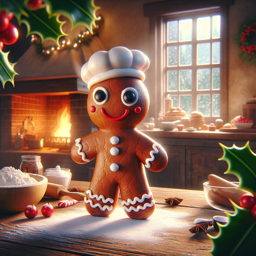

{
    'character_appearence': 'The gingerbread man moving swiftly through a busy village, expressing excitement and 
movement.',
    'style_attributes': 'Photo-realistic capturing animated, lively energy, with a slight winter overlay of 
snowflakes.',
    'worn_and_carried': 'Minimal decoration with icing and candy.',
    'scenario': 'Village scene with cobblestone streets, villagers chasing him, and market stalls tumbling. 
Snowflakes gently falling.'
}

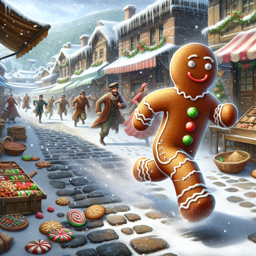

{
    'character_appearence': 'The gingerbread man, joyful and adventurous, riding on a sleek reddish fox with 
twinkling eyes.',
    'style_attributes': 'Photo-realistic winter landscape with serene, crisp details and joyful undertones.',
    'worn_and_carried': 'Decorated with frosting.',
    'scenario': 'Snowy meadow under a clear blue sky, the fox bounding gracefully, leaving a trail of paw prints. 
Trees dusted with snow and distant villagers waving.'
}

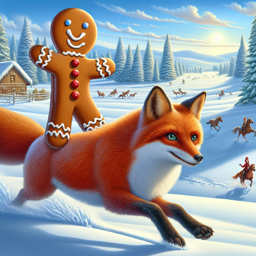

Editor:

The story and illustrations are delightful! Here’s some feedback:                                                  

Story:                                                                                                             

 • Structure and Flow: The narrative flows smoothly, with a clear beginning, middle, and end. The pacing keeps the 
   reader engaged throughout.                                                                                      
 • Characters: The gingerbread man is charming and spirited, and the fox adds a delightful twist. Consider adding a
   bit more dialogue to emphasize their personalities.                                                             
 • Setting: The descriptions of the village and the chase enhance the festive atmosphere. They effectively immerse 
   the reader in the story.                                                                                        

Illustrations:                                                                                                     

 1 Grandma Thompson's Kitchen: The cozy warmth and details like the holly leaves create a rich, inviting scene.    
 2 The Village Chase: The dynamic movement and detailed market stalls capture the excitement perfectly.            
 3 The Snowy Meadow Adventure: The serene landscape and joyful expressions beautifully convey the spirit of        
   adventure and friendship.                                                                                       

Overall Suggestions:                                                                                               

 • A touch more dialogue can enhance character development.                                                        
 • Ensure the illustrations align with specific moments in the story for consistency.                              

Once these adjustments are made, the short story and illustrations will be ready to captivate readers!

User:                                                       

APPROVE

In [17]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(
            content="Please write a short story about the gingerbread man with up to 3 photo-realistic illustrations.",
            source="User",
        )
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()

从输出中，您可以看到作家、插画师和编辑代理轮流发言并协作生成图画书，然后再向用户请求最终批准。

## 后续步骤

这个例子展示了群聊模式的一个简单实现 —— **它并不适合在实际应用中使用**。您可以改进发言者选择算法。例如，当简单规则足够且更可靠时，您可以避免使用 LLM：您可以使用一个规则，即编辑总是在作家之后发言。

[AgentChat API](../../agentchat-user-guide/index.md) 提供了选择器群聊的高级 API。它有更多功能，但大多与此实现共享相同的设计。